# Energy Consumption Forecasting Using Time Series Analysis
# Zaman Serisi Analizi ile Enerji Tüketimi Tahmini

---

## Introduction / Giriş

Bu projede saatlik enerji tüketim verileri kullanılarak geleceğe yönelik enerji tüketim tahmini yapılması amaçlanmaktadır. Enerji tüketimi zaman içerisinde belirli trendler ve mevsimsellik özellikleri göstermektedir. Bu nedenle zaman serisi analizi yöntemleri kullanılarak verinin yapısı incelenmiş ve tahmin modeli geliştirilmiştir.

Projenin amacı yalnızca tahmin yapmak değil, aynı zamanda enerji tüketimindeki örüntüleri anlamak, zaman bağlı davranışları analiz etmek ve makine öğrenmesi teknikleri ile anlamlı sonuçlar elde etmektir.

Bu çalışma, gerçek dünya enerji talebi tahmin problemlerine benzer bir senaryoyu simüle ederek zaman serisi modelleme konusunda pratik deneyim kazandırmayı hedeflemektedir.

---

## Dataset Description / Veri Seti Tanımı

Bu projede kullanılan veri seti Kaggle platformundan alınmıştır ve saatlik enerji tüketim ölçümlerini içermektedir.

Veri setinin temel özellikleri:

- Saatlik zaman damgası (timestamp)
- Enerji tüketim değerleri (MW cinsinden)
- Uzun dönemli zaman serisi (birden fazla yıl)

Bu veri seti:

- Trend içerir
- Mevsimsellik içerir
- Günlük ve haftalık döngüler içerir
- Gerçek dünya enerji tüketimini temsil eder

Zaman serisi yapısı nedeniyle veri sıralı bağımlılık gösterir ve klasik rastgele veri varsayımlarından farklı bir analiz gerektirir.

---

## Workflow / Proje Akış Şeması

Bu proje aşağıdaki adımlardan oluşmaktadır:

### 1. Data Loading / Verinin Yüklenmesi
Veri setinin yüklenmesi ve zaman indeksinin ayarlanması

### 2. Data Cleaning / Veri Temizleme
Eksik verilerin kontrol edilmesi ve düzeltilmesi

### 3. Exploratory Data Analysis (EDA) / Keşifsel Veri Analizi
Trend, mevsimsellik ve zaman bazlı örüntülerin incelenmesi

### 4. Feature Engineering / Özellik Mühendisliği
Lag özellikleri, saat, gün, ay gibi zaman özelliklerinin oluşturulması

### 5. Model Building / Model Kurulumu
Zaman serisi tahmin modelinin eğitilmesi

### 6. Model Evaluation / Model Değerlendirme
MAE / RMSE gibi metriklerle performans ölçümü

### 7. Forecast Visualization / Tahminlerin Görselleştirilmesi
Gelecek tahminlerinin grafiksel gösterimi

### 8. Model Saving / Modelin Kaydedilmesi
Eğitilmiş modelin kaydedilmesi ve deployment’a hazırlanması



In [1]:
from IPython.display import Image, display

In [2]:
display(Image(url='https://avenston.com/content/uploads/2019/01/energy-forecast-2050-ris1-1024x590.jpg', width=700))

## Libraries Used / Kullanılan Kütüphaneler

Bu projede zaman serisi analizi, veri işleme, modelleme ve görselleştirme için çeşitli Python kütüphaneleri kullanılmaktadır.

### NumPy
Sayısal hesaplamalar ve matematiksel işlemler için kullanılır.

### Pandas
Zaman serisi verilerini işlemek, temizlemek ve analiz etmek için kullanılır.

### Matplotlib & Seaborn
Veri görselleştirme ve trend analizleri için grafik çizmek amacıyla kullanılır.

### Scikit-learn
Model değerlendirme metrikleri ve veri bölme işlemleri için kullanılır.

### XGBoost
Zaman serisi tahmini için güçlü bir makine öğrenmesi algoritmasıdır.

### Datetime
Zaman damgalarını yönetmek ve zaman tabanlı özellikler üretmek için kullanılır.

### Joblib
Eğitilmiş modeli kaydetmek ve tekrar yüklemek için kullanılır.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import joblib
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading / Verinin Yüklenmesi

Bu adımda Kaggle’dan indirilen enerji tüketim veri seti yüklenir ve zaman serisi analizine uygun hale getirilir.

Zaman serisi projelerinde en kritik noktalardan biri zaman sütununun doğru biçimde tanınmasıdır. Bu nedenle tarih/saat sütunu datetime formatına çevrilir ve indeks olarak ayarlanır. Böylece veri kronolojik sıraya göre düzenlenmiş olur.

Ayrıca veri setinin ilk satırları incelenerek yapısı kontrol edilir.


### Dataset Selection / Veri Seti Seçimi

Kaggle veri seti birden fazla enerji bölgesine ait saatlik tüketim kayıtlarını içermektedir. Bu projede analiz sürecini daha anlaşılır ve yönetilebilir tutmak amacıyla yalnızca **AEP (American Electric Power)** bölgesine ait veri seçilmiştir.

AEP veri setinin tercih edilme nedenleri:

- Uzun zaman aralığını kapsaması
- Düzenli saatlik ölçümler içermesi
- Eksik veri oranının düşük olması
- Zaman serisi analizi için uygun yapıya sahip olması

Bu seçim, modeli tek bir bölge üzerinde derinlemesine analiz etmeye ve tahmin performansını daha net değerlendirmeye olanak sağlamaktadır.

In [4]:
df=pd.read_csv('AEP_hourly.csv')

In [5]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


## 2. Data Inspection & Cleaning / Veri İnceleme ve Temizleme

Bu adımda veri setinin boyutu, eksik değerleri ve genel yapısı kontrol edilir. Zaman serisi modellemesinde eksik veriler tahmin performansını olumsuz etkileyebileceği için temizleme işlemi kritik öneme sahiptir.

Bu aşamada:

- Veri boyutu kontrol edilir
- Eksik değerler incelenir
- Gerekirse temizleme işlemi uygulanır


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


### Datetime Conversion / Zaman Sütununun Dönüştürülmesi

Veri setinde zaman bilgisi şu anda *object* veri tipindedir. Zaman serisi analizi yapabilmek için bu sütunun datetime formatına dönüştürülmesi gerekir.

Datetime formatı, Pandas’ın zaman tabanlı işlemleri doğru şekilde gerçekleştirmesini sağlar. Bu dönüşüm yapılmadan zaman serisi modellemesi sağlıklı çalışmaz.

Bu nedenle Datetime sütunu datetime tipine çevrilir ve indeks olarak ayarlanır.


In [7]:
df['Datetime']=pd.to_datetime(df['Datetime'])

In [8]:
df.set_index('Datetime', inplace=True)

In [9]:
df.sort_index(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [11]:
df.isnull().sum()

AEP_MW    0
dtype: int64

### Missing Value Check / Eksik Veri Kontrolü

Eksik değerler zaman serisi tahmin modellerinde ciddi hatalara yol açabilir. Bu nedenle veri setinde eksik gözlem olup olmadığı kontrol edilmiştir.

Yapılan inceleme sonucunda veri setinde eksik değer bulunmamaktadır. Bu durum modelleme sürecinin ek bir temizleme adımına ihtiyaç duymadan ilerleyebileceğini göstermektedir.


In [12]:
df.shape

(121273, 1)

**** Veri seti toplam 121,273 gözlem ve 2 sütundan oluşmaktadır. Bu büyüklük, zaman serisi modellemesi için yeterli veri hacmi sağlamaktadır.


### Updated Data Structure / Güncellenmiş Veri Yapısı

Datetime dönüşümünden sonra veri setinin yapısı tekrar kontrol edilmiştir. Zaman sütunu başarıyla datetime indeksine dönüştürülmüş ve veri kronolojik sıraya göre düzenlenmiştir.

Artık veri seti zaman serisi analizi için hazır durumdadır.


### Time Range Overview / Zaman Aralığı İncelemesi

Veri setinin kapsadığı zaman aralığı incelenerek modelin hangi dönemleri içerdiği anlaşılır. Uzun zaman aralıkları, modelin trend ve mevsimselliği öğrenmesine yardımcı olur.


In [13]:
print('Start date:', df.index.min())

Start date: 2004-10-01 01:00:00


In [14]:
print('End date:', df.index.max())

End date: 2018-08-03 00:00:00


In [15]:
print('Total observation:', len(df))

Total observation: 121273


### Time Coverage Interpretation / Zaman Kapsamının Yorumlanması

Veri seti 2004 yılından 2018 yılına kadar yaklaşık 14 yıllık saatlik enerji tüketim verisini kapsamaktadır.

Bu kadar uzun bir zaman aralığı, modelin:

- uzun dönemli trendleri
- mevsimsel döngüleri
- günlük ve yıllık tüketim davranışlarını

öğrenmesi için yeterli veri sağlamaktadır. Bu durum tahmin modelinin daha güçlü ve genellenebilir olmasına katkı sağlar.


## 3. Exploratory Data Analysis (EDA) / Keşifsel Veri Analizi

Bu bölümde enerji tüketim verisi görselleştirilerek zaman içindeki davranışı incelenir. Amaç, trendleri, mevsimselliği ve olası dalgalanmaları gözlemlemektir.

EDA süreci, modelleme öncesinde veriyi anlamak için kritik öneme sahiptir. Grafikler sayesinde enerji tüketiminin zamanla nasıl değiştiği görsel olarak analiz edilir.


### Time Series Visualization / Zaman Serisi Görselleştirme

Bu grafik, saatlik enerji tüketiminin yıllar içindeki değişimini göstermektedir. Uzun dönemli trendler ve dalgalanmalar bu görselleştirme ile incelenebilir.


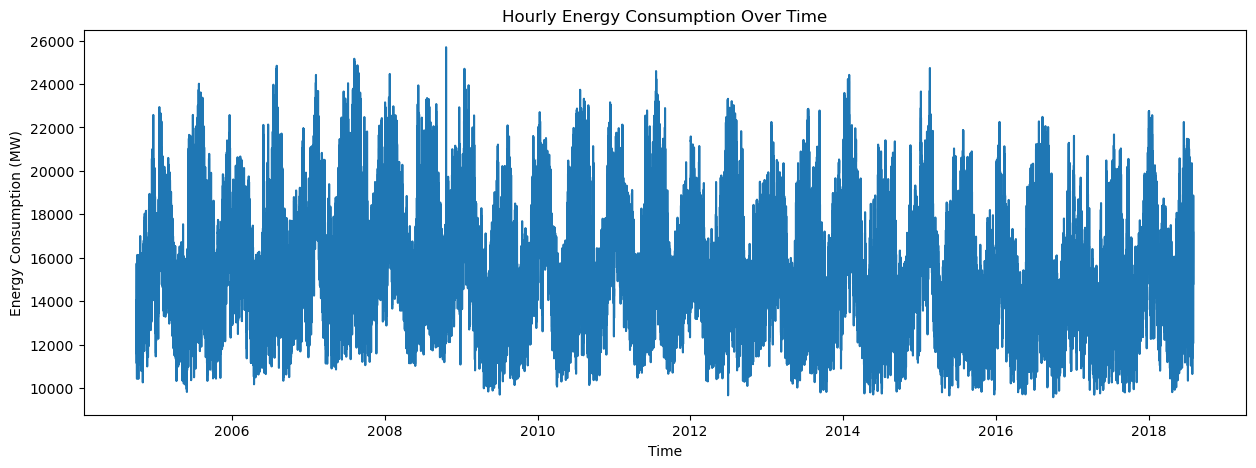

In [16]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['AEP_MW'])
plt.title("Hourly Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (MW)")
plt.show()

### Trend Observation / Trend Gözlemi

Zaman serisi grafiği incelendiğinde enerji tüketiminin yıllar boyunca dalgalı bir yapı gösterdiği görülmektedir.

Bu dalgalanmalar, enerji tüketimindeki mevsimsel değişimleri ve günlük kullanım alışkanlıklarını yansıtmaktadır. Aynı zamanda uzun vadede genel bir trend hareketi gözlemlenmektedir.

Bu yapı, verinin hem trend hem de mevsimsellik içerdiğini ve zaman serisi modellemesi için uygun olduğunu göstermektedir.


### Yearly Zoom / Yıllık Yakınlaştırma

Tüm zaman aralığı yerine tek bir yıl seçilerek enerji tüketimindeki yıllık mevsimsel davranış incelenir. Bu yaklaşım, büyük grafikte kaybolan detayları daha net görmemizi sağlar.


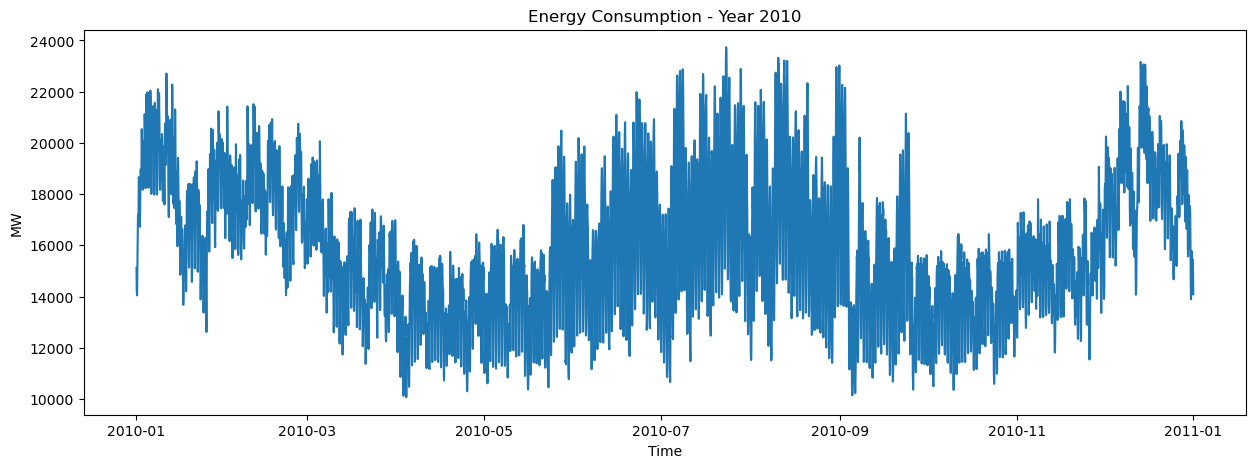

In [17]:
df_2010 = df.loc["2010"]

plt.figure(figsize=(15,5))
plt.plot(df_2010.index, df_2010['AEP_MW'])
plt.title("Energy Consumption - Year 2010")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()

### Weekly Zoom / Haftalık Yakınlaştırma

Bir haftalık zaman dilimi seçilerek günlük tekrar eden tüketim davranışları incelenir.


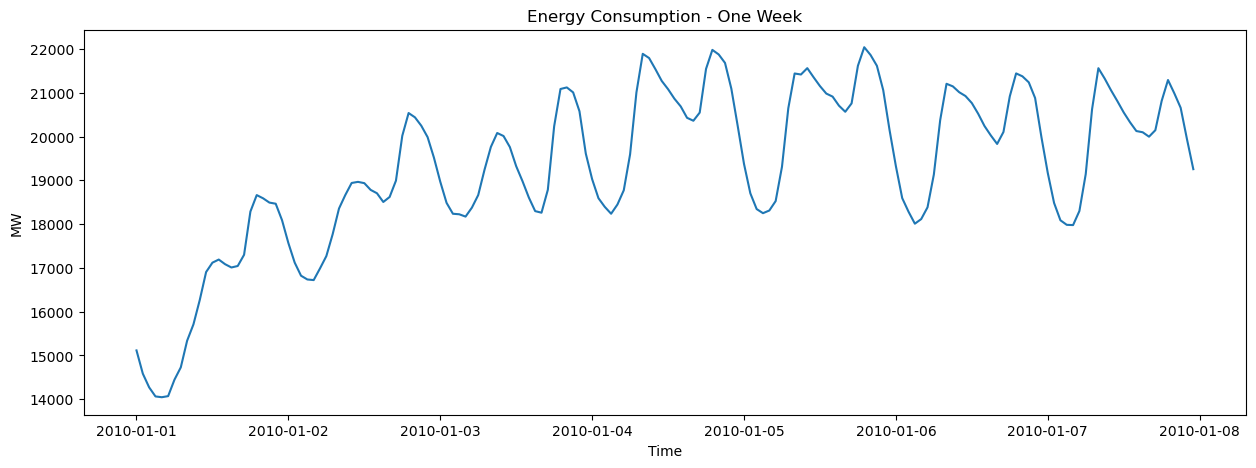

In [18]:
week = df.loc["2010-01-01":"2010-01-07"]

plt.figure(figsize=(15,5))
plt.plot(week.index, week['AEP_MW'])
plt.title("Energy Consumption - One Week")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()

### Daily Zoom / Günlük Yakınlaştırma

Tek bir gün incelenerek saatlik enerji tüketim döngüsü gözlemlenir.


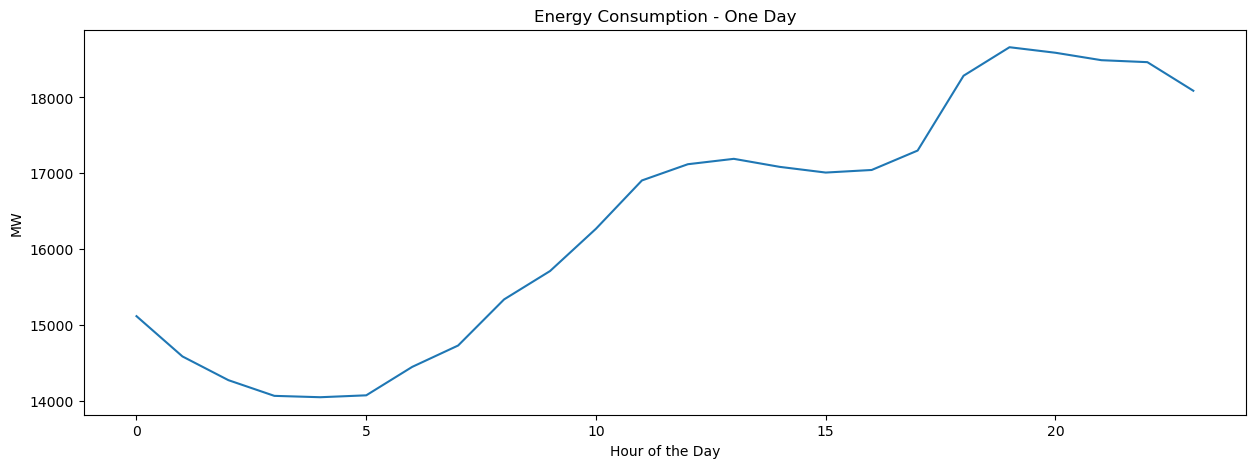

In [19]:
day = df.loc["2010-01-01"]

plt.figure(figsize=(15,5))
plt.plot(day.index.hour, day['AEP_MW'])
plt.title("Energy Consumption - One Day")
plt.xlabel("Hour of the Day")
plt.ylabel("MW")
plt.show()

### Daily Consumption Pattern / Günlük Tüketim Davranışı

Günlük yakınlaştırma grafiği incelendiğinde enerji tüketiminin belirli bir döngü izlediği görülmektedir.

Sabah saat 05:00 civarında tüketim artmaya başlamakta, gün içerisinde yüksek seviyelere ulaşmakta ve gece saatlerine doğru tekrar düşmektedir. Bu davranış, insanların günlük yaşam ritmi ve endüstriyel faaliyetlerle doğrudan ilişkilidir.

Bu düzenli tekrar eden yapı, veride güçlü bir günlük mevsimsellik olduğunu göstermektedir. Bu tür örüntüler zaman serisi modellemesi sırasında önemli bir avantaj sağlar.


### Average Consumption by Hour / Saatlere Göre Ortalama Tüketim

Bu analizde günün her saati için ortalama enerji tüketimi hesaplanır. Amaç, saatlik kullanım davranışını sayısal olarak incelemektir.

Bu tür analizler, günlük mevsimselliği doğrular ve modelleme aşamasında saat bilgisi gibi zaman tabanlı özelliklerin kullanılmasının neden önemli olduğunu gösterir.


In [20]:
df['hour']=df.index.hour

In [21]:
hourly_avg = df.groupby('hour')['AEP_MW'].mean()

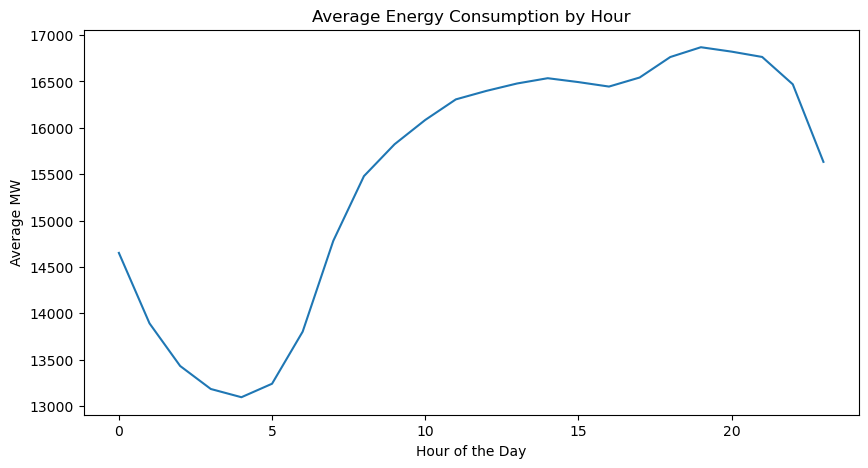

In [22]:
plt.figure(figsize=(10,5))
hourly_avg.plot()
plt.title("Average Energy Consumption by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average MW")
plt.show()

### Hourly Pattern Interpretation / Saatlik Örüntü Yorumu

Saatlik ortalama tüketim grafiği incelendiğinde enerji kullanımının gün içinde belirli bir ritim izlediği görülmektedir.

Tüketim akşam saat 17:00–20:00 arasında en yüksek seviyeye ulaşmaktadır. Bu durum, iş çıkışı saatleri ve akşam ev içi kullanımın artmasıyla açıklanabilir.

En düşük tüketim ise gece 04:00–05:00 saatleri arasında gözlemlenmektedir. Bu saatlerde hem bireysel hem de endüstriyel faaliyetlerin azalması enerji talebini düşürmektedir.

Bu düzenli yapı, veride güçlü bir günlük mevsimsellik olduğunu ve saat bilgisinin modelleme sürecinde önemli bir özellik olacağını göstermektedir.


### Average Consumption by Day of Week / Haftanın Günlerine Göre Ortalama Tüketim

Bu analizde haftanın her günü için ortalama enerji tüketimi hesaplanır. Amaç, hafta içi ve hafta sonu tüketim davranışlarını karşılaştırmaktır.

Bu tür haftalık örüntüler, zaman serisi modellemesinde önemli bir mevsimsellik bileşenidir.


In [23]:
df['dayofweek'] = df.index.dayofweek

In [24]:
daily_avg = df.groupby('dayofweek')['AEP_MW'].mean()

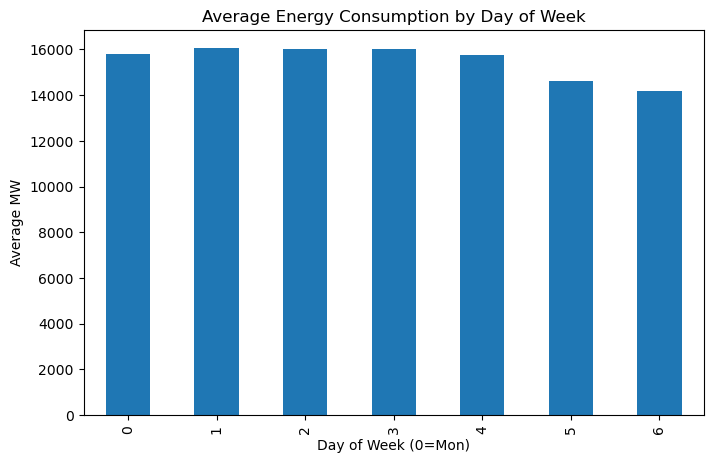

In [25]:
plt.figure(figsize=(8,5))
daily_avg.plot(kind='bar')
plt.title("Average Energy Consumption by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Average MW")
plt.show()

### Weekly Pattern Interpretation / Haftalık Örüntü Yorumu

Haftanın günlerine göre ortalama tüketim incelendiğinde hafta sonlarında enerji kullanımının belirgin şekilde düştüğü görülmektedir.

En yüksek tüketim Salı, Çarşamba ve Perşembe günlerinde gerçekleşmektedir. Bu durum, hafta içi endüstriyel ve ticari faaliyetlerin yoğunluğuyla ilişkilidir.

Hafta sonu tüketim düşüşü ise ekonomik aktivitenin azalması ve ev dışı kullanımın azalmasıyla açıklanabilir.

Bu haftalık örüntü, zaman serisinde güçlü bir haftalık mevsimsellik bulunduğunu göstermektedir.


### Average Consumption by Month / Aylara Göre Ortalama Tüketim

Bu analizde her ay için ortalama enerji tüketimi hesaplanır. Amaç, mevsimsel davranışları incelemek ve yıl içindeki tüketim değişimini anlamaktır.

Enerji tüketimi genellikle yaz ve kış aylarında artış gösterir. Bu artışlar klima ve ısıtma kullanımından kaynaklanır.


In [26]:
df['month'] = df.index.month

In [27]:
monthly_avg = df.groupby('month')['AEP_MW'].mean()

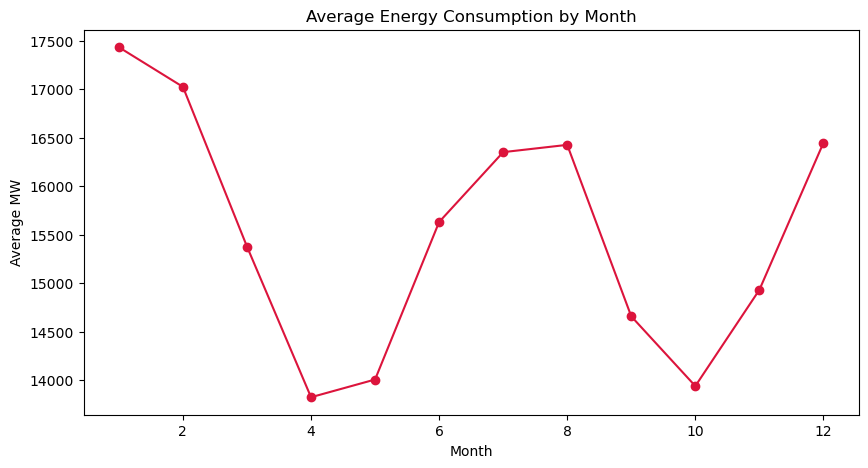

In [28]:
plt.figure(figsize=(10,5))
monthly_avg.plot(color='crimson', marker='o')
plt.title("Average Energy Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Average MW")
plt.show()

### Seasonal Pattern Interpretation / Mevsimsel Örüntü Yorumu

Aylık ortalama tüketim grafiği incelendiğinde enerji kullanımının belirgin bir mevsimsellik gösterdiği görülmektedir.

En yüksek tüketim Ocak ayında gerçekleşmektedir. Bu durum, kış aylarında artan ısıtma ihtiyacı ile açıklanabilir. Mayıs–Ağustos arasında tüketim tekrar yükselmektedir ancak bu artış kış aylarındaki kadar yüksek değildir. Yaz dönemindeki artış büyük ölçüde klima kullanımından kaynaklanmaktadır.

Nisan ayında tüketim en düşük seviyededir. Bu dönem, genellikle ısıtma ve soğutma ihtiyacının minimum olduğu geçiş mevsimine karşılık gelir.

Ekim ayından itibaren tüketimin yeniden yükselmeye başladığı gözlemlenmektedir. Bu artış yaklaşan kış sezonunun erken etkilerini göstermektedir.

Bu bulgular, zaman serisinde güçlü bir yıllık mevsimsellik bulunduğunu ve modelleme sürecinde ay bilgisinin önemli bir özellik olacağını göstermektedir.



### Climate Insight from Energy Usage / Enerji Tüketiminden İklim Yorumu

Enerji tüketim verisi incelendiğinde kış aylarında belirgin bir artış olduğu görülmektedir. Bu durum, bölgenin soğuk iklim koşullarına sahip olduğunu ve ısıtma ihtiyacının enerji talebini önemli ölçüde artırdığını düşündürmektedir.

Yaz aylarında da tüketimde artış gözlense de bu artış kış dönemindeki kadar yüksek değildir. Bu durum, ısıtmanın soğutmaya kıyasla daha büyük bir enerji ihtiyacı oluşturduğunu göstermektedir.

Dolayısıyla enerji tüketim desenleri, bölgenin iklim özellikleri hakkında dolaylı fakat güçlü bir gösterge sunmaktadır.


## 4. Feature Engineering / Özellik Mühendisliği

Bu bölümde zaman serisi verisinden modele yardımcı olacak yeni özellikler üretilir.

Zaman serisi tahmin problemlerinde geçmiş değerler ve zaman bileşenleri geleceği tahmin etmek için kritik öneme sahiptir. Bu nedenle saat, gün ve ay gibi zaman tabanlı özellikler oluşturulur.

Ayrıca geçmiş tüketim değerlerini temsil eden lag(geçmiş değer) özellikleri eklenerek modelin geçmiş davranışlardan öğrenmesi sağlanır.

Feature engineering aşaması, model performansını doğrudan etkileyen en önemli adımlardan biridir.


### 4.1 Time-Based Features / Zaman Tabanlı Özellikler

Zaman serisinden saat, gün, ay ve yıl bilgileri çıkarılarak yeni özellikler oluşturulur.

Bu özellikler, modelin günlük, haftalık ve mevsimsel örüntüleri öğrenmesini sağlar. EDA sırasında gözlemlenen tüketim davranışları bu zaman bileşenleri sayesinde modele aktarılmış olur.


In [29]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [30]:
df.head()

,AEP_MW,hour,dayofweek,month,year
Datetime,,,,,
2004-10-01 01:00:00,12379.0,1,4,10,2004
2004-10-01 02:00:00,11935.0,2,4,10,2004
2004-10-01 03:00:00,11692.0,3,4,10,2004
2004-10-01 04:00:00,11597.0,4,4,10,2004
2004-10-01 05:00:00,11681.0,5,4,10,2004


### 4.2 Lag Features / Gecikmeli Özellikler

Lag özellikleri geçmiş zaman noktalarındaki tüketim değerlerini temsil eder. Bu özellikler sayesinde model geçmiş davranışları öğrenerek geleceği tahmin edebilir.

Bu projede üç temel lag kullanılmıştır:

- lag_1 → bir önceki saat
- lag_24 → bir gün önce aynı saat
- lag_168 → bir hafta önce aynı saat

Bu özellikler zaman serisini makine öğrenmesi problemine dönüştürmenin temelini oluşturur.


In [31]:
df['lag_1'] = df['AEP_MW'].shift(1)
df['lag_24'] = df['AEP_MW'].shift(24)
df['lag_168'] = df['AEP_MW'].shift(168)

In [32]:
df.head(30)

,AEP_MW,hour,dayofweek,month,year,lag_1,lag_24,lag_168
Datetime,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,10,2004,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,10,2004,12379.0,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,10,2004,11935.0,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,10,2004,11692.0,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,10,2004,11597.0,NaN,NaN
2004-10-01 06:00:00,12280.0,6,4,10,2004,11681.0,NaN,NaN
2004-10-01 07:00:00,13692.0,7,4,10,2004,12280.0,NaN,NaN
2004-10-01 08:00:00,14618.0,8,4,10,2004,13692.0,NaN,NaN
2004-10-01 09:00:00,14903.0,9,4,10,2004,14618.0,NaN,NaN


### 4.3  Removing Missing Values After Lag Creation / Lag Sonrası Eksik Değerlerin Temizlenmesi

Lag özellikleri oluşturulduktan sonra veri setinin baş kısmında doğal olarak eksik değerler oluşur. Bunun nedeni geçmiş gözlemlerin henüz mevcut olmamasıdır.

Makine öğrenmesi modelleri eksik değerlerle çalışamayacağı için bu satırlar veri setinden çıkarılır.


In [33]:
df=df.dropna()

In [34]:
df.head()

,AEP_MW,hour,dayofweek,month,year,lag_1,lag_24,lag_168
Datetime,,,,,,,,
2004-10-08 01:00:00,12468.0,1,4,10,2004,13271.0,12484.0,12379.0
2004-10-08 02:00:00,12046.0,2,4,10,2004,12468.0,12054.0,11935.0
2004-10-08 03:00:00,11749.0,3,4,10,2004,12046.0,11745.0,11692.0
2004-10-08 04:00:00,11784.0,4,4,10,2004,11749.0,11757.0,11597.0
2004-10-08 05:00:00,11919.0,5,4,10,2004,11784.0,12041.0,11681.0


In [35]:
df.isnull().sum()

AEP_MW       0
hour         0
dayofweek    0
month        0
year         0
lag_1        0
lag_24       0
lag_168      0
dtype: int64

### Final Feature Set / Nihai Özellik Seti

Lag ve zaman tabanlı özellikler oluşturulduktan sonra model için kullanılacak nihai veri seti hazır hale gelmiştir. Bu veri seti artık makine öğrenmesi modeline girdi olarak verilebilir.


In [36]:
df.head()

,AEP_MW,hour,dayofweek,month,year,lag_1,lag_24,lag_168
Datetime,,,,,,,,
2004-10-08 01:00:00,12468.0,1,4,10,2004,13271.0,12484.0,12379.0
2004-10-08 02:00:00,12046.0,2,4,10,2004,12468.0,12054.0,11935.0
2004-10-08 03:00:00,11749.0,3,4,10,2004,12046.0,11745.0,11692.0
2004-10-08 04:00:00,11784.0,4,4,10,2004,11749.0,11757.0,11597.0
2004-10-08 05:00:00,11919.0,5,4,10,2004,11784.0,12041.0,11681.0


In [37]:
df.shape

(121105, 8)

### Feature Engineering Completed / Özellik Mühendisliği Tamamlandı

Zaman tabanlı özellikler ve lag değişkenleri başarıyla oluşturulmuş ve eksik değerler temizlenmiştir.

Son veri seti 121,105 gözlem ve 8 özellik içermektedir. Bu yapı, modelleme aşaması için hazır durumdadır.


## 5. Model Building / Model Kurulumu

Bu aşamada oluşturulan özellikler kullanılarak zaman serisi tahmin modeli eğitilir.

Öncelikle bağımsız değişkenler (x) ve hedef değişken (y) ayrılır. Model, geçmiş tüketim ve zaman tabanlı özellikleri kullanarak gelecekteki enerji tüketimini tahmin etmeyi öğrenir.


In [38]:
x = df.drop('AEP_MW', axis=1)
y = df['AEP_MW']

In [39]:
x.head()

,hour,dayofweek,month,year,lag_1,lag_24,lag_168
Datetime,,,,,,,
2004-10-08 01:00:00,1,4,10,2004,13271.0,12484.0,12379.0
2004-10-08 02:00:00,2,4,10,2004,12468.0,12054.0,11935.0
2004-10-08 03:00:00,3,4,10,2004,12046.0,11745.0,11692.0
2004-10-08 04:00:00,4,4,10,2004,11749.0,11757.0,11597.0
2004-10-08 05:00:00,5,4,10,2004,11784.0,12041.0,11681.0


### Feature Matrix Explanation / Özellik Matrisi Açıklaması

Oluşturulan x veri seti, modelin kullanacağı bağımsız değişkenleri içermektedir. Bu matris yalnızca tahmin için gerekli özelliklerden oluşmaktadır:

- saat bilgisi (hour)
- haftanın günü (dayofweek)
- ay bilgisi (month)
- yıl bilgisi (year)
- geçmiş tüketimi temsil eden lag değişkenleri

Hedef değişken olan enerji tüketimi (AEP_MW) x veri setinden çıkarılmıştır. Bu durum veri sızıntısını (data leakage) önlemek için gereklidir.

Model yalnızca geçmiş bilgilerden öğrenerek geleceği tahmin edecektir. Bu yapı zaman serisi tahmin problemleri için doğru feature düzenini temsil etmektedir.


### 5.1 Train-Test Split for Time Series / Zaman Serisi İçin Veri Bölme

Zaman serisi problemlerinde veri rastgele bölünmez. Gelecek verilerin geçmişe karışmaması için kronolojik sıraya göre ayrım yapılır.

Bu projede verinin %80’i eğitim, %20’si test için ayrılmıştır. Test seti geleceği temsil eder.


In [40]:
split = int(len(df) * 0.8)

x_train = x.iloc[:split]
x_test = x.iloc[split:]

y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [41]:
print("Train size:", x_train.shape)
print("Test size:", x_test.shape)

Train size: (96884, 7)
Test size: (24221, 7)


### Train-Test Split Result / Eğitim-Test Bölme Sonucu

Veri seti kronolojik sıraya göre %80 eğitim ve %20 test olacak şekilde ayrılmıştır.

Eğitim seti 96,884 gözlem içerirken test seti 24,221 gözlemden oluşmaktadır. Bu yapı, modelin geçmiş verilerle öğrenmesini ve geleceği temsil eden test verisi üzerinde değerlendirilmesini sağlar.

Feature sayısı 7 olup model yalnızca geçmiş tüketim ve zaman tabanlı bilgileri kullanarak tahmin yapacaktır.


### 5.2 Training the Model / Model Eğitimi

Bu aşamada XGBoost regresyon modeli kullanılarak enerji tüketimi tahmin modeli eğitilir.

XGBoost, karmaşık örüntüleri öğrenebilen güçlü bir makine öğrenmesi algoritmasıdır. Lag ve zaman tabanlı özellikler sayesinde model geçmiş davranışları öğrenerek gelecekteki tüketimi tahmin etmeyi amaçlar.


In [42]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42)

model.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### 5.3 Model Prediction / Model Tahmini

Eğitilen model test veri seti üzerinde tahmin yapar. Bu tahminler, modelin gelecekteki enerji tüketimini ne kadar iyi öğrendiğini değerlendirmek için kullanılır.


In [43]:
y_pred = model.predict(x_test)

In [44]:
y_pred[:5]

array([14668.374, 14693.826, 13885.182, 13033.334, 12175.301],
      dtype=float32)

## 6. Model Evaluation / Model Değerlendirme

Model performansı MAE (Mean Absolute Error) ve RMSE (Root Mean Squared Error) metrikleri ile değerlendirilir.

MAE ortalama tahmin hatasını gösterirken, RMSE büyük hatalara daha fazla ağırlık verir. Bu metrikler modelin tahmin kalitesini sayısal olarak ölçmemizi sağlar.


In [45]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [46]:
mae

136.12240068503314

In [47]:
rmse

np.float64(181.55056446546695)

### 6.1  Model Performance Interpretation / Model Performans Yorumu

Modelin ortalama mutlak hatası (MAE) yaklaşık 136 MW olarak ölçülmüştür. Enerji tüketim değerlerinin 10,000–20,000 MW aralığında olduğu düşünüldüğünde bu hata oranı oldukça düşüktür.

RMSE değeri yaklaşık 181 MW olup büyük hataların da sınırlı olduğunu göstermektedir.

Bu sonuçlar modelin enerji tüketimini yüksek doğrulukla tahmin edebildiğini ve güçlü bir performans sergilediğini göstermektedir.


## 7. Forecast Visualization / Tahminlerin Görselleştirilmesi

Bu bölümde modelin tahminleri ile gerçek enerji tüketim değerleri karşılaştırılır. Grafik, modelin zaman içindeki davranışı ne kadar iyi takip ettiğini görsel olarak gösterir.


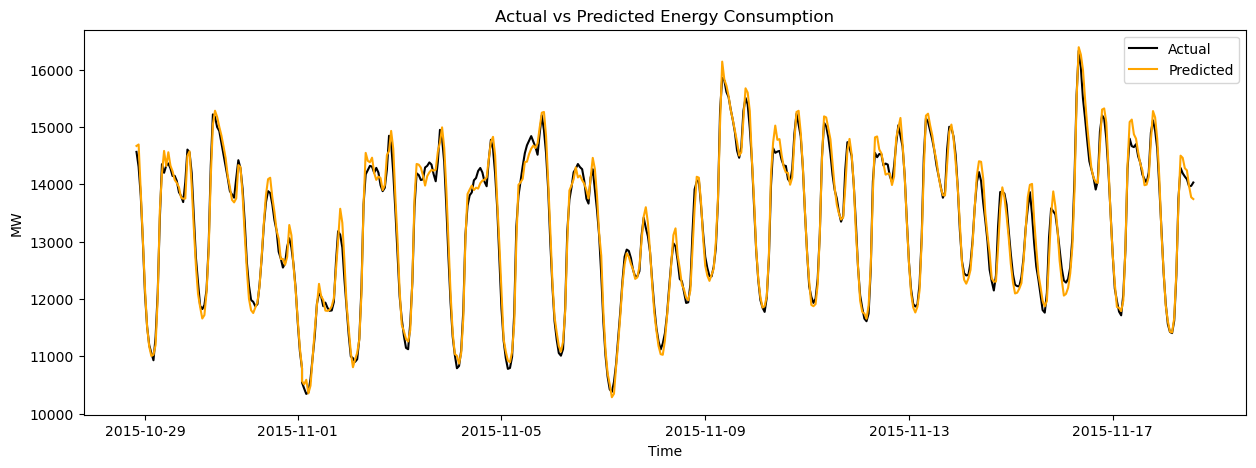

In [48]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(15,5))

plt.plot(y_test[:500], label="Actual", color="black")
plt.plot(y_pred_series[:500], label="Predicted", color="orange")

plt.title("Actual vs Predicted Energy Consumption")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.show()

### 7.1 Forecast Interpretation / Tahmin Yorumu

Gerçek ve tahmin edilen değerler karşılaştırıldığında modelin enerji tüketimindeki dalgalanmaları başarıyla takip ettiği görülmektedir.

Tahmin eğrisi gerçek verinin akışını büyük ölçüde yansıtmaktadır. Bu durum modelin hem günlük hem mevsimsel örüntüleri doğru öğrendiğini göstermektedir.

Grafiksel sonuçlar, sayısal performans metrikleriyle uyumlu şekilde güçlü bir tahmin başarısına işaret etmektedir.


### Additional Model: Random Forest / Ek Model: Random Forest

Model performansını karşılaştırmak amacıyla ikinci bir makine öğrenmesi modeli olarak Random Forest algoritması kullanılmıştır.

Farklı modellerin aynı problem üzerindeki performansını karşılaştırmak, en uygun yaklaşımı belirlemek açısından önemlidir.


In [49]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1)

rf_model.fit(x_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [50]:
rf_pred = rf_model.predict(x_test)

### Random Forest Evaluation / Random Forest Değerlendirmesi


In [51]:
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

In [52]:
rf_mae

147.09626770158124

In [53]:
rf_rmse

np.float64(197.48236285573418)

### Model Comparison / Model Karşılaştırması

XGBoost ve Random Forest modellerinin performansları karşılaştırılmıştır.

XGBoost modeli daha düşük MAE ve RMSE değerleri üretmiştir. Bu sonuç, XGBoost’un enerji tüketimindeki karmaşık örüntüleri Random Forest modeline kıyasla daha iyi öğrendiğini göstermektedir.

Her iki model de güçlü performans sergilese de XGBoost daha yüksek doğruluk sağladığı için nihai model olarak seçilmiştir.


| Model | MAE | RMSE |
|------|------|------|
| XGBoost | 136 | 181 |
| Random Forest | 147 | 197 |


## 8. Model Saving / Modelin Kaydedilmesi

Karşılaştırma sonucunda en iyi performansı gösteren XGBoost modeli seçilmiş ve tekrar kullanılabilmesi için kaydedilmiştir.

Modelin kaydedilmesi deployment ve uygulama geliştirme süreçleri için önemlidir. Bu sayede model yeniden eğitilmeye gerek kalmadan yüklenebilir ve tahmin için kullanılabilir.


In [54]:
joblib.dump(model, "energy_forecast_xgboost.pkl")

['energy_forecast_xgboost.pkl']

In [55]:
reqs = """
numpy
pandas
matplotlib
seaborn
scikit-learn
xgboost
joblib
streamlit
"""

with open("requirements.txt", "w") as f:
    f.write(reqs)

print("requirements.txt created")


requirements.txt created


# Conclusion / Sonuç

Bu projede saatlik enerji tüketimi verileri kullanılarak zaman serisi tahmin modeli geliştirilmiştir. Keşifsel veri analizi sayesinde veride güçlü günlük, haftalık ve mevsimsel örüntüler olduğu gözlemlenmiştir. Bu örüntüler feature engineering aşamasında modele aktarılmıştır.

Lag özellikleri ve zaman tabanlı değişkenler kullanılarak makine öğrenmesi modelleri eğitilmiş, XGBoost ve Random Forest modelleri karşılaştırılmıştır. Performans değerlendirmesi sonucunda XGBoost modelinin daha yüksek doğruluk sağladığı görülmüş ve nihai model olarak seçilmiştir.

Model hem sayısal metrikler hem de grafiksel karşılaştırmalar açısından güçlü bir tahmin performansı göstermiştir. Bu çalışma, zaman serisi modellemesinin gerçek dünya enerji tahmin problemlerine nasıl uygulanabileceğini göstermektedir.

Proje, veri analizi, özellik mühendisliği ve model karşılaştırmasının bir arada kullanıldığı uçtan uca bir zaman serisi tahmin pipeline’ı sunmaktadır.



## Real-World Scenario / Gerçek Hayat Senaryosu

Enerji tüketimi tahmini gerçek dünyada kritik öneme sahiptir. Elektrik dağıtım şirketleri, enerji üreticileri ve şehir planlama kurumları bu tür tahminleri operasyonel kararlar almak için kullanır.

Bu projede geliştirilen model, geçmiş saatlik enerji tüketim verilerinden öğrenerek gelecekteki talebi tahmin edebilmektedir. Bu tür bir sistem gerçek hayatta şu alanlarda kullanılabilir:

- Elektrik üretim planlaması
- Enerji arz-talep dengesi
- Şebeke yük yönetimi
- Aşırı tüketim risklerinin önceden tahmini
- Akıllı şehir enerji optimizasyonu

Doğru tahminler enerji maliyetlerini düşürür, kesintileri azaltır ve sürdürülebilir enerji yönetimine katkı sağlar.

Bu proje, endüstride kullanılan enerji tahmin sistemlerinin küçük ölçekli bir simülasyonu olarak değerlendirilebilir.
